# **Pokemón Diffusion Overfitting<a id="top"></a>**

<i><small>**Alumno:** Alejandro Pequeño Lizcano</small></i></div>

---

**Objetivo:** 
Este notebook tiene como objetivo forzar el overfitting de un modelo de difusión para poder analizar su comportamiento y entender cómo se comporta en un entorno controlado y poder arreglar posibles fallos en el código.

- [0. Imports](#-0.-Imports)

- [1. Dataset](#-1.-Dataset)
    - [1.1. Predataset](##-1.1.-Predataset)
    - [1.2. Dataset](##-1.2.-Dataset)

- [2. Modelo de Difusión](#-2.-Modelo-de-Difusión)
    - [2.1. Forward Diffusion](##-2.1.-Forward-Diffusion)
    - [2.2. Reverse Diffusion](##-2.2.-Reverse-Diffusion)
    - [2.3. Train Diffusion Model](##-2.3.-Train-Diffusion-Model)

---

# 0. Imports

In [1]:
# Import necessary libraries
# =====================================================================

# Import visualization libraries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Import libraries for data preprocessing
import numpy as np
import pandas as pd
from tqdm.auto import trange, tqdm  # progress bar

# Import libraries for data and folder manipulation
import random
import os
import json

# Import libraries from tensorflow for building the model
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers

# Import necessary libraries
# =====================================================================
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import configparser
import tensorflow as tf

# Import src code
from src.data.create_dataset import *
from src.model.build_unet import build_unet
from src.utils.utils import *
from src.visualization import visualize

# from src.model.diffusion_model import *
from src.model.overfitting_test import *

/home/pqlza/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-04-23 15:34:15.120720: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-23 15:34:15.153653: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Use the GPU
# =====================================================================
gpus_list = tf.config.list_physical_devices("GPU")
gpu = gpus_list[0]
tf.config.experimental.set_memory_growth(gpu, True)

print("GPUs Available: ", gpus_list)

GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-04-23 15:34:16.043510: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-23 15:34:16.047282: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-23 15:34:16.047387: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [3]:
# Set config file
# =====================================================================
config = configparser.ConfigParser()
config.read(PROJECT_DIR / "config.ini")

# Hyperparameters
config_hp = config["hyperparameters"]

IMG_SIZE = 64
NUM_CLASSES = int(config_hp["num_classes"])
BATCH_SIZE = 32
EPOCHS = 100
T = 200
BETA_START = float(config_hp["beta_start"])
BETA_END = float(config_hp["beta_end"])
s = float(config_hp["s"])  # scale factor for the variance curve
SCHEDULER = config_hp["scheduler"]

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)  # TODO: ADD TO CONFIG FILE
loss_fn = tf.keras.losses.MeanSquaredError()

2024-04-23 15:34:16.057592: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-23 15:34:16.057730: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-23 15:34:16.057798: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [4]:
# load df and data_dict
# =====================================================================
path = f"{DATA_PATH}/processed/pokedex_cleaned.csv"
df = pd.read_csv(path)

with open(f"{DATA_PATH}/interim/pokemon_dict_dataset.json", "r") as f:
    data_dict = json.load(f)

from src.data.path_loader import PathLoader as pl

loader = pl(
    load_pattern=f"{DATA_PATH}/raw/sprites/**/front/**/*.png",
)

# Load the paths from the file
image_paths = loader.load_paths()

from src.data.create_dataset import dataset_dict

data_dict = dataset_dict(image_paths=image_paths, df=df)

Loading paths...

- Number of paths loaded: 8143



- The shape of the dataset is: (32, 64, 64, 3) => batch_size: 32, height: 64, width: 64, channels: 3
- The shape of the dataset labels is: (32, 18) => batch_size: 32, number of labels: 18


2024-04-23 15:34:17.213522: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


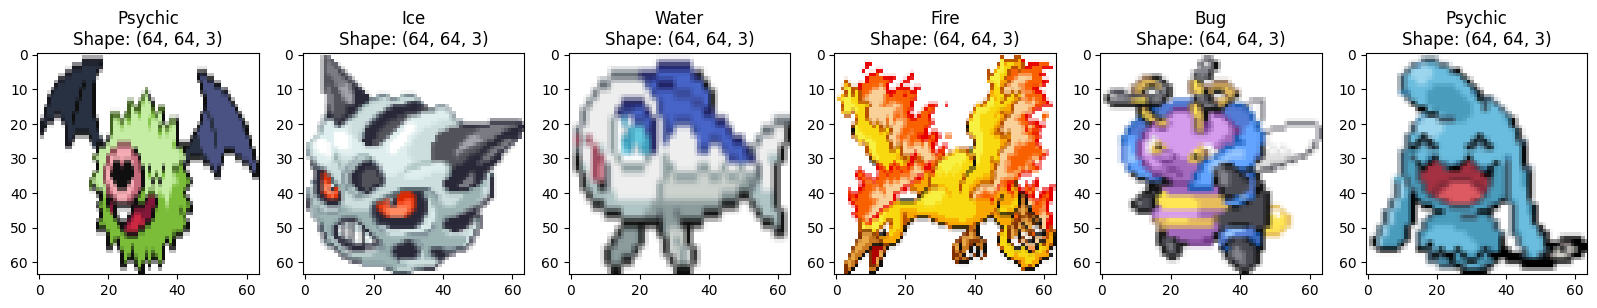

2024-04-23 15:34:17.750415: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [5]:
# dataset_path = f"{DATA_PATH}/processed/pokemon_tf_dataset"
# poke_dataset = tf.data.Dataset.load(path=dataset_path, compression="GZIP")

poke_dataset = dataset_tf(
    df=df,
    dict_dataset=data_dict,
    img_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)

# Check the dataset
# =====================================================================
for img, label in poke_dataset.take(1):
    print(
        f"- The shape of the dataset is: {img.shape} => batch_size: {img.shape[0]}, height: {img.shape[1]}, width: {img.shape[2]}, channels: {img.shape[3]}"
    )
    print(
        f"- The shape of the dataset labels is: {label.shape} => batch_size: {label.shape[0]}, number of labels: {label.shape[1]}"
    )

# Visualize the dataset
visualize.plot_images_batch(dataset_tf=poke_dataset, n=6)

<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>
(32, 64, 64, 3)
(32, 18)


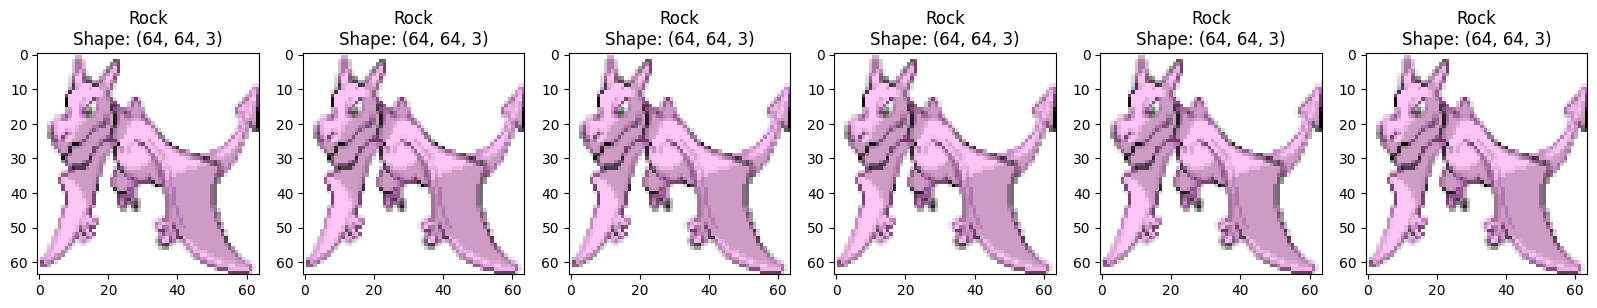

2024-04-23 15:34:52.705936: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-04-23 15:34:52.706859: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [34]:
# get one batch of the dataset
dataset_example = poke_dataset.take(1)

# get one specific image of the batch
for img, label in dataset_example:
    img_example = img[0]
    label_example = label[0]
    break

# get only one image of the dataset
for img, label in dataset_example:
    img_example = img[0]
    label_example = label[0]
    break

img_example = np.expand_dims(img_example, axis=0)  # expand the image to the batch size
label_example = np.expand_dims(
    label_example, axis=0
)  # expand the label to the batch size

dataset_example = tf.data.Dataset.from_tensor_slices((img_example, label_example))

dataset_example = dataset_example.repeat(512).batch(BATCH_SIZE)

for img, label in dataset_example:
    print(type(img), type(label))
    print(img.shape)
    print(label.shape)
    break

for img, label in dataset_example.take(1):
    label_example = label[0]
    visualize.plot_images_batch(dataset_tf=dataset_example)

In [35]:
label_example

<tf.Tensor: shape=(18,), dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0.], dtype=float32)>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


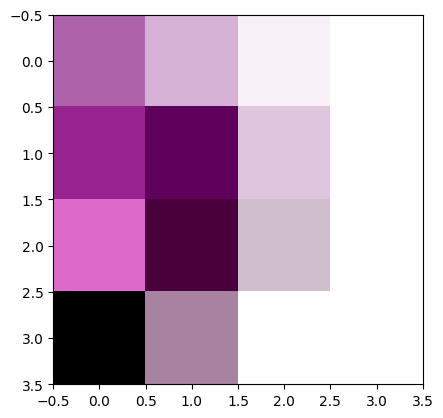

In [36]:
# get the image and the label
for img, label in dataset_example.take(1):
    img_example = img[0]
    label_example = label[0]
    break

# get the coordinates of the bottom right corner of the pokemon
x = 60
y = 60
w = 30
h = 30

# Slice the tensor to get the pixel values within the background area
img_white_area = img_example[y : y + h, x : x + w, :]

plt.imshow(img_white_area)

In [37]:
# Create the model
# =====================================================================
u_net = build_unet(IMG_SIZE, NUM_CLASSES)
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model = DiffusionModel(
    u_net, IMG_SIZE, NUM_CLASSES, T, BETA_START, BETA_END, s, "linear"
)

# Compile the model
# =====================================================================
model.compile(loss=loss_fn, optimizer=optimizer)

Epoch 1/100


2024-04-23 15:35:02.493050: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906
2024-04-23 15:35:04.496629: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.33GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 310ms/step - loss: 1.0636
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 311ms/step - loss: 0.8344
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 313ms/step - loss: 0.7111
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 310ms/step - loss: 0.5779
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 312ms/step - loss: 0.3923
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 310ms/step - loss: 0.3004
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 310ms/step - loss: 0.3067
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 313ms/step - loss: 0.3082
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 312ms/step - loss: 0.1574
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - loss: 0.2114Epoch 10: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 23.88it/s]


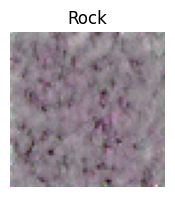

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 898ms/step - loss: 0.1990
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 309ms/step - loss: 0.1293
Epoch 12/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 324ms/step - loss: 0.3235
Epoch 13/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 322ms/step - loss: 0.1833
Epoch 14/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - loss: 0.1279
Epoch 15/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.1309
Epoch 16/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 325ms/step - loss: 0.1572
Epoch 17/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 325ms/step - loss: 0.1877
Epoch 18/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 331ms/step - loss: 0.1221
Epoch 19/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 326ms/step - loss: 0.1839
Epoch 20/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - loss: 0.2332Epoch 20: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 23.08it/s]


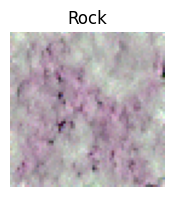

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 944ms/step - loss: 0.2194
Epoch 21/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 328ms/step - loss: 0.1276
Epoch 22/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 327ms/step - loss: 0.0803
Epoch 23/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 326ms/step - loss: 0.1150
Epoch 24/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 327ms/step - loss: 0.1499
Epoch 25/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 322ms/step - loss: 0.1116
Epoch 26/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 324ms/step - loss: 0.2466
Epoch 27/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 324ms/step - loss: 0.2303
Epoch 28/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 331ms/step - loss: 0.1739
Epoch 29/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 325ms/step - loss: 0.1058
Epoch 30/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - loss: 0.2290Epoch 30: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 23.18it/s]


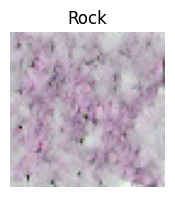

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 914ms/step - loss: 0.2155
Epoch 31/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 325ms/step - loss: 0.0983
Epoch 32/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 330ms/step - loss: 0.0991
Epoch 33/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 323ms/step - loss: 0.1729
Epoch 34/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 326ms/step - loss: 0.0662
Epoch 35/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - loss: 0.1274
Epoch 36/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 330ms/step - loss: 0.0677
Epoch 37/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - loss: 0.0806
Epoch 38/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0705
Epoch 39/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 329ms/step - loss: 0.0895
Epoch 40/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - loss: 0.0843Epoch 40: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 23.67it/s]


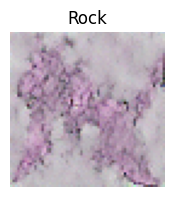

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 913ms/step - loss: 0.0794
Epoch 41/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 332ms/step - loss: 0.0668
Epoch 42/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 329ms/step - loss: 0.0535
Epoch 43/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 332ms/step - loss: 0.0585
Epoch 44/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 330ms/step - loss: 0.1340
Epoch 45/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 333ms/step - loss: 0.0953
Epoch 46/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 322ms/step - loss: 0.0972
Epoch 47/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 328ms/step - loss: 0.0948
Epoch 48/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 324ms/step - loss: 0.1526
Epoch 49/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 332ms/step - loss: 0.0834
Epoch 50/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - loss: 0.2420Epoch 50: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 23.08it/s]


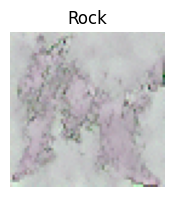

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 932ms/step - loss: 0.2277
Epoch 51/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 329ms/step - loss: 0.2028
Epoch 52/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 325ms/step - loss: 0.0941
Epoch 53/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 334ms/step - loss: 0.2057
Epoch 54/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 333ms/step - loss: 0.1754
Epoch 55/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 329ms/step - loss: 0.1089
Epoch 56/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 330ms/step - loss: 0.1720
Epoch 57/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 327ms/step - loss: 0.1303
Epoch 58/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 322ms/step - loss: 0.0662
Epoch 59/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - loss: 0.0607
Epoch 60/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - loss: 0.2100Epoch 60: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:09<00:00, 22.05it/s]


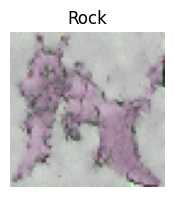

16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 950ms/step - loss: 0.1976
Epoch 61/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 331ms/step - loss: 0.0965
Epoch 62/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 330ms/step - loss: 0.0818
Epoch 63/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - loss: 0.0990
Epoch 64/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 324ms/step - loss: 0.0901
Epoch 65/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 328ms/step - loss: 0.0720
Epoch 66/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 329ms/step - loss: 0.0892
Epoch 67/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - loss: 0.0523
Epoch 68/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 333ms/step - loss: 0.0439
Epoch 69/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 326ms/step - loss: 0.1541
Epoch 70/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - loss: 0.0605Epoch 70: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 23.60it/s]


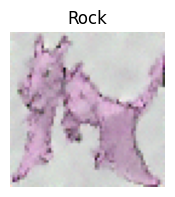

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 920ms/step - loss: 0.0570
Epoch 71/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 324ms/step - loss: 0.0779
Epoch 72/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0409
Epoch 73/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0580
Epoch 74/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0944
Epoch 75/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - loss: 0.0745
Epoch 76/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.2210
Epoch 77/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - loss: 0.1123
Epoch 78/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.1685
Epoch 79/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.1194
Epoch 80/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - loss: 0.0954Epoch 80: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 24.02it/s]


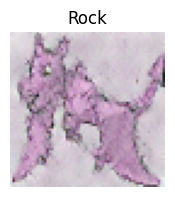

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 898ms/step - loss: 0.0898
Epoch 81/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0541
Epoch 82/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0500
Epoch 83/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0791
Epoch 84/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0544
Epoch 85/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0638
Epoch 86/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 313ms/step - loss: 0.0519
Epoch 87/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0746
Epoch 88/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0300
Epoch 89/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0519
Epoch 90/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - loss: 0.0641Epoch 90: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 24.32it/s]


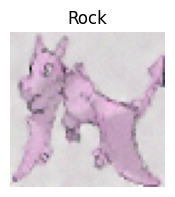

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 892ms/step - loss: 0.0603
Epoch 91/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 313ms/step - loss: 0.0529
Epoch 92/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 312ms/step - loss: 0.1318
Epoch 93/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.1154
Epoch 94/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.1131
Epoch 95/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0380
Epoch 96/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0397
Epoch 97/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0870
Epoch 98/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.1200
Epoch 99/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - loss: 0.0568
Epoch 100/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - loss: 0.0419Epoch 100: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 23.62it/s]


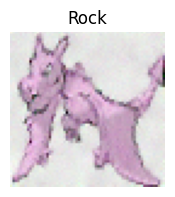

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 912ms/step - loss: 0.0395


In [38]:
tf.config.run_functions_eagerly(True)  # to debug the model
# model.fit(
#     dataset_example,
#     epochs=EPOCHS,
#     callbacks=[PlottingCallback(model, 6), DiffusionCallback(model, 20, "Electric")],
# )
str_label_example = onehot_to_string(label_example)
model.fit(
    dataset_example,
    epochs=EPOCHS,
    callbacks=[DiffusionCallback(model, 10, str_label_example)],
)

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.1027
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 313ms/step - loss: 0.0629
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - loss: 0.2343
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.1107
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - loss: 0.1357
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.1152
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0815
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0574
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - loss: 0.0706
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - loss: 0.0572Epoch 10: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 24.60it/s]


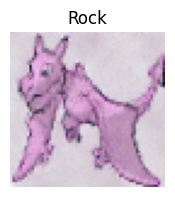

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 883ms/step - loss: 0.0538
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0976
Epoch 12/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0438
Epoch 13/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0306
Epoch 14/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.1015
Epoch 15/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0427
Epoch 16/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.1983
Epoch 17/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - loss: 0.0641
Epoch 18/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - loss: 0.0384
Epoch 19/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0326
Epoch 20/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - loss: 0.0306Epoch 20: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 24.05it/s]


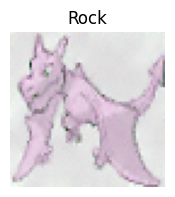

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 895ms/step - loss: 0.0288
Epoch 21/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0349
Epoch 22/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0594
Epoch 23/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 311ms/step - loss: 0.0260
Epoch 24/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 311ms/step - loss: 0.0514
Epoch 25/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0410
Epoch 26/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - loss: 0.0309
Epoch 27/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - loss: 0.0708
Epoch 28/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0496
Epoch 29/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0461
Epoch 30/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - loss: 0.0311Epoch 30: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 24.59it/s]


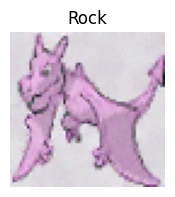

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 885ms/step - loss: 0.0292
Epoch 31/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - loss: 0.1203
Epoch 32/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0395
Epoch 33/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0422
Epoch 34/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0686
Epoch 35/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0990
Epoch 36/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.1016
Epoch 37/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.1300
Epoch 38/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0425
Epoch 39/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0428
Epoch 40/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - loss: 0.0907Epoch 40: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 24.23it/s]


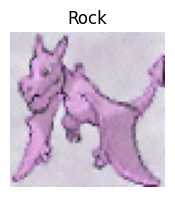

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 892ms/step - loss: 0.0854
Epoch 41/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - loss: 0.1711
Epoch 42/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0718
Epoch 43/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - loss: 0.0344
Epoch 44/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0663
Epoch 45/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0580
Epoch 46/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - loss: 0.0510
Epoch 47/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0514
Epoch 48/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0629
Epoch 49/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0422
Epoch 50/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - loss: 0.0242Epoch 50: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 23.91it/s]


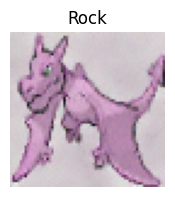

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 900ms/step - loss: 0.0227
Epoch 51/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0231
Epoch 52/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0423
Epoch 53/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0237
Epoch 54/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0179
Epoch 55/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0259
Epoch 56/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0272
Epoch 57/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.0681
Epoch 58/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0632
Epoch 59/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0863
Epoch 60/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - loss: 0.1344Epoch 60: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 23.88it/s]


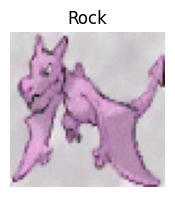

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 899ms/step - loss: 0.1265
Epoch 61/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0713
Epoch 62/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - loss: 0.0334
Epoch 63/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0582
Epoch 64/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0361
Epoch 65/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0276
Epoch 66/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0331
Epoch 67/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0506
Epoch 68/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0927
Epoch 69/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - loss: 0.0547
Epoch 70/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - loss: 0.0413Epoch 70: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 23.25it/s]


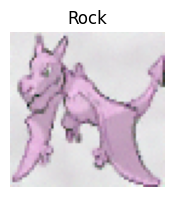

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 921ms/step - loss: 0.0388
Epoch 71/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0375
Epoch 72/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0276
Epoch 73/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0229
Epoch 74/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0280
Epoch 75/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - loss: 0.0322
Epoch 76/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0460
Epoch 77/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0339
Epoch 78/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 326ms/step - loss: 0.0336
Epoch 79/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 322ms/step - loss: 0.0591
Epoch 80/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - loss: 0.0844Epoch 80: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 23.71it/s]


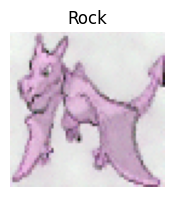

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 908ms/step - loss: 0.0795
Epoch 81/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0316
Epoch 82/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0340
Epoch 83/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - loss: 0.0308
Epoch 84/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0341
Epoch 85/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - loss: 0.0444
Epoch 86/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 323ms/step - loss: 0.0807
Epoch 87/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 325ms/step - loss: 0.0933
Epoch 88/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - loss: 0.1206
Epoch 89/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - loss: 0.0904
Epoch 90/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - loss: 0.0768Epoch 90: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 23.68it/s]


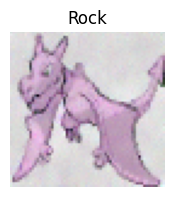

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 915ms/step - loss: 0.0723
Epoch 91/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0568
Epoch 92/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0673
Epoch 93/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - loss: 0.0217
Epoch 94/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 323ms/step - loss: 0.0383
Epoch 95/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0578
Epoch 96/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - loss: 0.0323
Epoch 97/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - loss: 0.0197
Epoch 98/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 326ms/step - loss: 0.0360
Epoch 99/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - loss: 0.0857
Epoch 100/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - loss: 0.1123Epoch 100: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 23.63it/s]


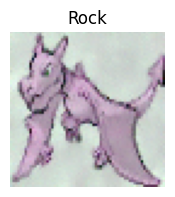

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 913ms/step - loss: 0.1057


In [39]:
model.fit(
    dataset_example,
    epochs=100,
    callbacks=[DiffusionCallback(model, 10, str_label_example)],
)

In [ ]:
# model.fit(
#     dataset_example,
#     epochs=200,
#     callbacks=[DiffusionCallback(model, 10, str_label_example)],
# )

Generating sample 1/1


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 23.11it/s]


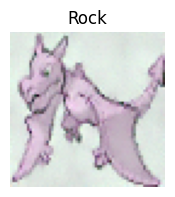

In [40]:
model.plot_samples(1, str_label_example)

Generating sample 1/3


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 24.15it/s]


Generating sample 2/3


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 24.53it/s]


Generating sample 3/3


Sampling sprite: 100%|██████████| 199/199 [00:08<00:00, 24.01it/s]


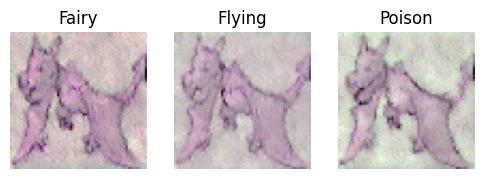

In [41]:
model.plot_samples(3)

In [ ]:
# save model
# =====================================================================
# model.save(f"{PROJECT_DIR}/models/test_1.h5")

In [ ]:
# model = tf.keras.models.load_model(f"{PROJECT_DIR}/models/test_1.h5")

In [ ]:
# df = preprocess.load_csv("../../dataset/pokedex.csv")
# data_path = preprocess.load_paths_from_file("../../dataset/image_paths.json")
# data_dict = preprocess.dataset_dict(data_path, df)
# dataset = preprocess.create_dataset(data_dict, df, size=IMG_SIZE, batch_size=BATCH_SIZE)
# label_mappping = preprocess.create_label_mapping(df)

# def generate_em(num_classes: int = NUM_CLASSES) -> np.ndarray:
#     """Generates a random embedding (label)

#     :param num_classes: The number of classes
#     """

#     em = np.zeros(num_classes)
#     em[np.where(label_example[0] == 1)[0][0]] = 1
#     return em


# generate_em()
# plotter.onehot_to_string(generate_em(), label_mappping)